In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil

In [2]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import Callback
import tensorflow as tf

In [3]:
from keract import get_activations

In [4]:
#!wget https://github.com/philipperemy/keras-attention-mechanism/raw/master/attention/attention.py

In [5]:
from layers.attention import Attention #Luong

In [6]:
def task_add_two_numbers_after_delimiter(n: int, seq_length: int, delimiter: float = 0.0,
                                         index_1: int = None, index_2: int = None) -> (np.array, np.array):
    """
    Task: Add the two numbers that come right after the delimiter.
    x = [1, 2, 3, 0, 4, 5, 6, 0, 7, 8]. Result is y = 4 + 7 = 11.
    @param n: number of samples in (x, y).
    @param seq_length: length of the sequence of x.
    @param delimiter: value of the delimiter. Default is 0.0
    @param index_1: index of the number that comes after the first 0.
    @param index_2: index of the number that comes after the second 0.
    @return: returns two numpy.array x and y of shape (n, seq_length, 1) and (n, 1).
    """
    x = np.random.uniform(0, 1, (n, seq_length))
    y = np.zeros(shape=(n, 1))
    for i in range(len(x)):
        if index_1 is None and index_2 is None:
            a, b = np.random.choice(range(1, len(x[i])), size=2, replace=False)
        else:
            a, b = index_1, index_2
        y[i] = x[i, a:a + 1] + x[i, b:b + 1]#0.5 * x[i, a:a + 1] + 0.5 * x[i, b:b + 1]
        x[i, a - 1:a] = delimiter
        x[i, b - 1:b] = delimiter
    x = np.expand_dims(x, axis=-1)
    return x, y


In [7]:
seq_length = 10
x_train, y_train = task_add_two_numbers_after_delimiter(20_000, seq_length)
x_val, y_val = task_add_two_numbers_after_delimiter(4_000, seq_length)

In [8]:
x_val.shape, y_val.shape

((4000, 10, 1), (4000, 1))

In [9]:
# just arbitrary values. it's for visual purposes. easy to see than random values.
test_index_1 = 4
test_index_2 = 9
x_test, _ = task_add_two_numbers_after_delimiter(10, seq_length, 0, test_index_1, test_index_2)
# x_test_mask is just a mask that, if applied to x_test, would still contain the information to solve the problem.
# we expect the attention map to look like this mask.
x_test_mask = np.zeros_like(x_test[..., 0])
x_test_mask[:, test_index_1:test_index_1 + 1] = 1
x_test_mask[:, test_index_2:test_index_2 + 1] = 1

In [10]:
model_input = Input(shape=(seq_length, 1))
x = LSTM(100, return_sequences=True)(model_input)
x = Attention()(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='linear')(x)
model = Model(model_input, x)
model.compile(loss='mae', optimizer='adam')


In [11]:
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 10, 100)      40800       input_1[0][0]                    
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 100)          0           lstm[0][0]                       
__________________________________________________________________________________________________
attention_score_vec (Dense)     (None, 10, 100)      10000       lstm[0][0]                       
_______________________________________________________________________________________

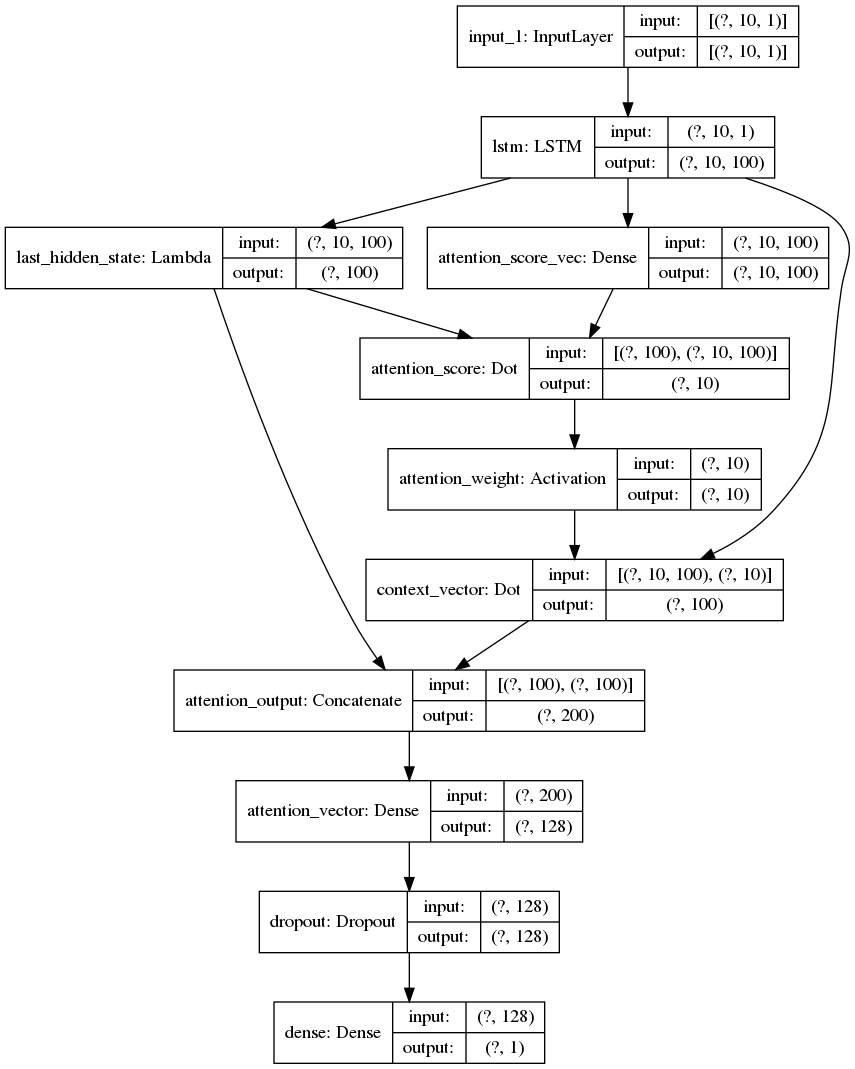

In [12]:
tf.keras.utils.plot_model(model, to_file="model_hello_luong.png", show_shapes=True)

In [13]:
output_dir = Path('out_task_add_two_numbers')
if output_dir.exists():
    shutil.rmtree(str(output_dir))
output_dir.mkdir(parents=True, exist_ok=True)

In [14]:
class VisualiseAttentionMap(Callback):
    def on_epoch_end(self, epoch, logs=None):
        attention_map = get_activations(model, x_test)['attention_weight']
        # top is attention map, bottom is ground truth.
        plt.imshow(np.concatenate([attention_map, x_test_mask]), cmap='hot')
        iteration_no = str(epoch).zfill(3)
        plt.axis('off')
        plt.title(f'Iteration {iteration_no} / {max_epoch}')
        plt.savefig(f'{output_dir}/epoch_{iteration_no}.png')
        plt.close()

In [15]:
max_epoch = 100

In [16]:
# train.
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val),
              epochs=max_epoch, verbose=2, batch_size=64,
              callbacks=[VisualiseAttentionMap()])

Epoch 1/100
313/313 - 2s - loss: 0.3142 - val_loss: 0.2944
Epoch 2/100
313/313 - 2s - loss: 0.2983 - val_loss: 0.2837
Epoch 3/100
313/313 - 2s - loss: 0.2871 - val_loss: 0.2769
Epoch 4/100
313/313 - 2s - loss: 0.2812 - val_loss: 0.2776
Epoch 5/100
313/313 - 2s - loss: 0.2763 - val_loss: 0.2646
Epoch 6/100
313/313 - 2s - loss: 0.2616 - val_loss: 0.2567
Epoch 7/100
313/313 - 2s - loss: 0.2416 - val_loss: 0.2225
Epoch 8/100
313/313 - 2s - loss: 0.2181 - val_loss: 0.2093
Epoch 9/100
313/313 - 2s - loss: 0.1876 - val_loss: 0.1657
Epoch 10/100
313/313 - 2s - loss: 0.1665 - val_loss: 0.1449
Epoch 11/100
313/313 - 2s - loss: 0.1482 - val_loss: 0.1423
Epoch 12/100
313/313 - 2s - loss: 0.1400 - val_loss: 0.1228
Epoch 13/100
313/313 - 2s - loss: 0.1317 - val_loss: 0.1276
Epoch 14/100
313/313 - 2s - loss: 0.1264 - val_loss: 0.1162
Epoch 15/100
313/313 - 2s - loss: 0.1230 - val_loss: 0.1172
Epoch 16/100
313/313 - 2s - loss: 0.1192 - val_loss: 0.1110
Epoch 17/100
313/313 - 2s - loss: 0.1169 - val_lo

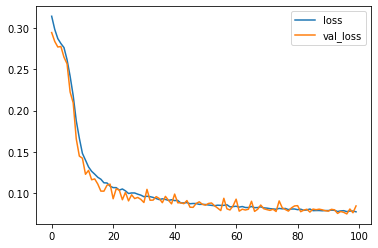

In [17]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [18]:
# test save/reload model.
pred1 = model.predict(x_val)
model.save('test_model.h5')
model_h5 = load_model('test_model.h5')
pred2 = model_h5.predict(x_val)
np.testing.assert_almost_equal(pred1, pred2)
print('Success.')

Success.


In [26]:
x = [[1, 2, 3, 0, 4, 5, 6, 0, 7, 8]]

x = np.expand_dims(x, 2)
x = x/np.max(x)
print(x.shape)

(1, 10, 1)


In [27]:
model.predict(x)

array([[1.3888258]], dtype=float32)

In [28]:
0.5+0.875

1.375

In [29]:
x

array([[[0.125],
        [0.25 ],
        [0.375],
        [0.   ],
        [0.5  ],
        [0.625],
        [0.75 ],
        [0.   ],
        [0.875],
        [1.   ]]])

Refernce
* https://github.com/philipperemy/keras-attention-mechanism/blob/master/examples/add_two_numbers.py